<a href="https://colab.research.google.com/github/Dominique2021/aai-iot-linear-regression/blob/main/Assignment_3_1_Linear_Regression_for_IoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression



## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 1 in this assignment. 

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean.txt")


In [4]:
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [5]:
df.dtypes

Unnamed: 0                 int64
Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Datetime                  object
gap_monthly              float64
grp_monthly              float64
v_monthly                float64
gi_monthly               float64
dtype: object

In [6]:
#convert datetime to epoch/unix time
df['time'] = datetime.datetime(2021, 3, 1, 12, 0, 0)  # year, month, day, hour, minute, second

# convert to Unix timestamp
timestamp = df['time']

print(timestamp)  # output: 1614580800.0



0       2021-03-01 12:00:00
1       2021-03-01 12:00:00
2       2021-03-01 12:00:00
3       2021-03-01 12:00:00
4       2021-03-01 12:00:00
                ...        
35579   2021-03-01 12:00:00
35580   2021-03-01 12:00:00
35581   2021-03-01 12:00:00
35582   2021-03-01 12:00:00
35583   2021-03-01 12:00:00
Name: time, Length: 35584, dtype: datetime64[ns]


## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: 

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [26]:
ts = pd.DataFrame(df.time)
ys = pd.DataFrame(df.Global_active_power)

ph = 5*60 #5 minutes
ph_index = round(ph/60)
mu = 0.09

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:The first data point would have very little influence on the 5000th prediction. The model would place much more weight on the more recent data points.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [8]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i-1]
    ys_tmp = ys[0:1]
    
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for w in range(ns):
      weights[w] = weights[w]**w
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

   #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[1,0]
    tp_unix = int(tp.timestamp())
    yp = (m_tmp * tp.timestamp()).item() + q_tmp.item()

    # add the timedelta to the Timestamp object
    tp_pred[1,2] = tp + yp
    yp_pred[1,2] = yp





TypeError: ignored

Now let's visualize the results from our model.

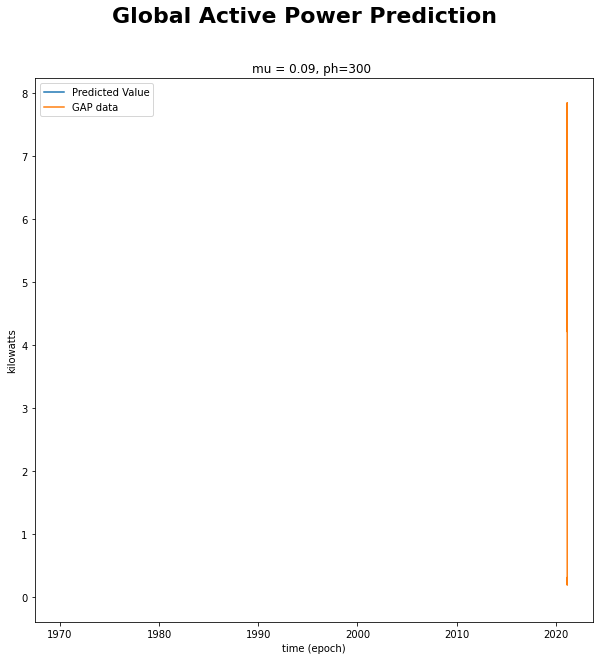

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:n_s-1], yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the RMSE for our predictions.**

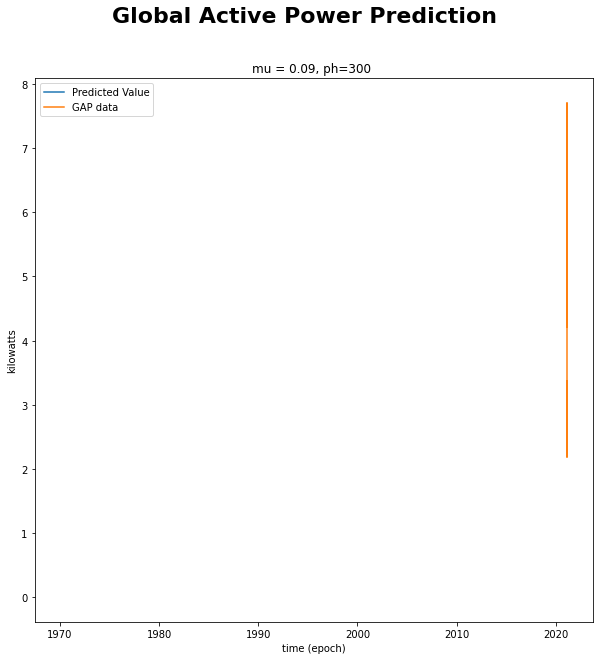

In [10]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


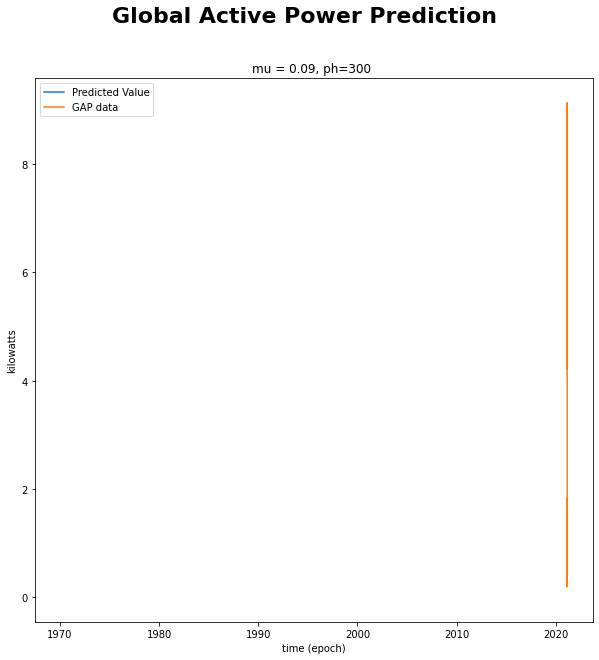

In [11]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:-200], yp_pred[:-200], label='Predicted Value') 
ax.plot(ts.iloc[0:-200,0], ys.iloc[0:-200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [12]:
#Calculate RMSE of 
from sklearn.metrics import mean_squared_error

# calculate the RMSE of the predictions
mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)


RMSE:  2.1549368256504664


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the RMSE tell you?**

A: The model worked but has errors. I would have expected the first iteration to not be as accurate as it should have been. As the model is refined it should become more accurate. 

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the RMSE for each of these sets of predictions.**

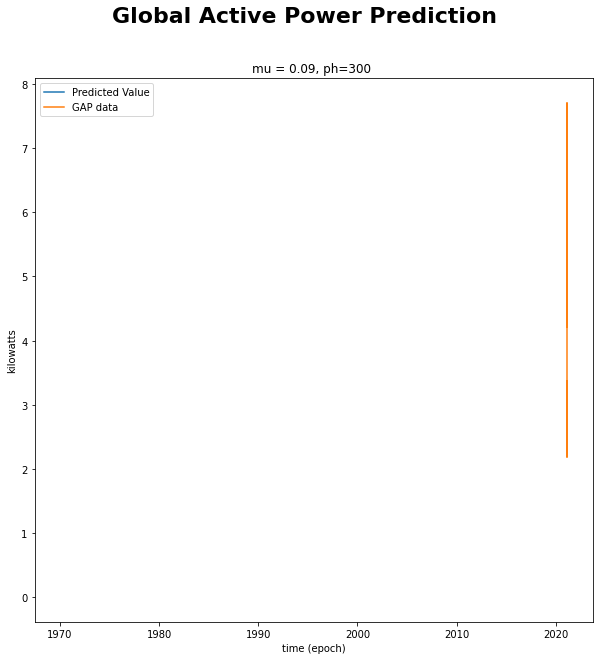

In [13]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

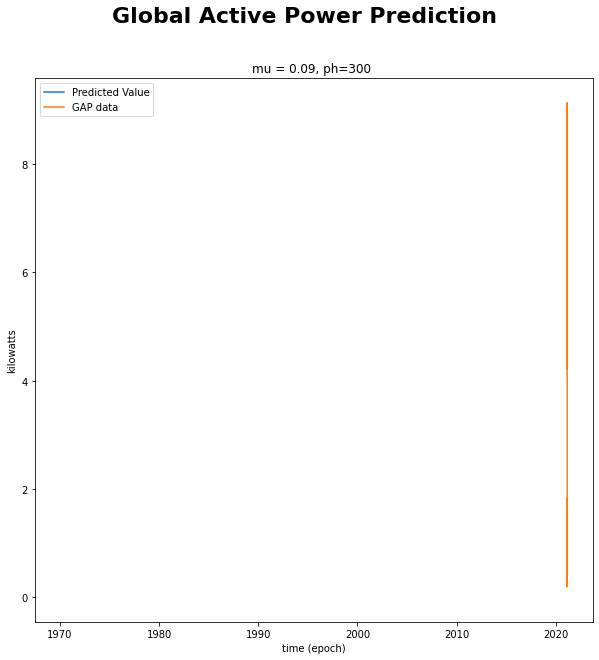

In [14]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:-200], yp_pred[:-200], label='Predicted Value') 
ax.plot(ts.iloc[0:-200,0], ys.iloc[0:-200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [15]:
#Calculate RMSE of predictions for mu = 1
mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)


RMSE:  2.1549368256504664


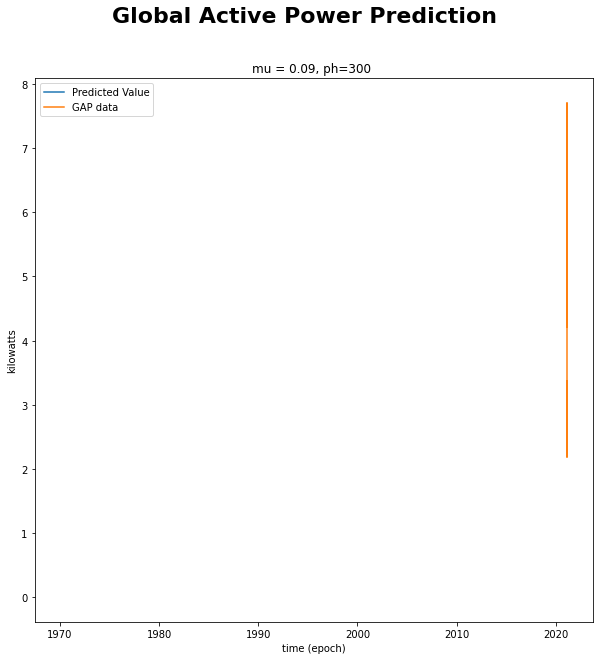

In [16]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

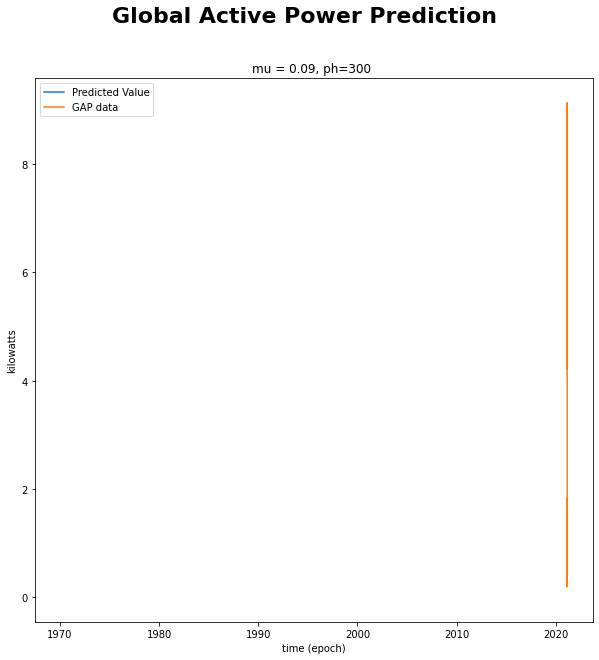

In [17]:
#Plot last 200 data points/predictions for mu = 0.01
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:-200], yp_pred[:-200], label='Predicted Value') 
ax.plot(ts.iloc[0:-200,0], ys.iloc[0:-200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [18]:
#Calculate RMSE of predictions for mu = 0.01
mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)


RMSE:  2.1549368256504664


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the RMSE tell you?**

A: When the model is changed to mu = 1 there didnt seem to be much of a change from when mu = 9. 

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the RMSE tell you?**

A: Due to errors in the model, I was unable to test visualize the data, but I believe that future predictions will be more accurate because we will have sufficient data to refine the original model.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: This is difficult to determine with the model errors but I would expect the mu = 0.09 model to preform at least slightly better than the mu = 0.01 model.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: We could conduct additional data analysis to determine which variables are correlated and then use this knowledge to improve the model. For instance, we can increase the time from 5 minutes to 30 days.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the RMSE**

In [19]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({'time': df['time'], 'Voltage': df['Voltage']})
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [20]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
for i in range(3, n_s+1):
    # get x and y data "available" for our prediction
    ts_tmp = ts.iloc[i-3:i-1, :]
    ys_tmp = ys.iloc[i-3:i, :]
    ns = len(ys_tmp)
    
    weights = np.array([mu**(i-1-k) for k in range(ns)])
    weights = np.flip(weights, 0)
        
    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0]
    tp_unix = tp.timestamp()
    yp = np.dot(m_tmp, np.array([tp_unix, voltage_value])) + q_tmp
      
    tp_pred[1, i] = tp + ph
    yp_pred[1, i] = yp

TypeError: ignored

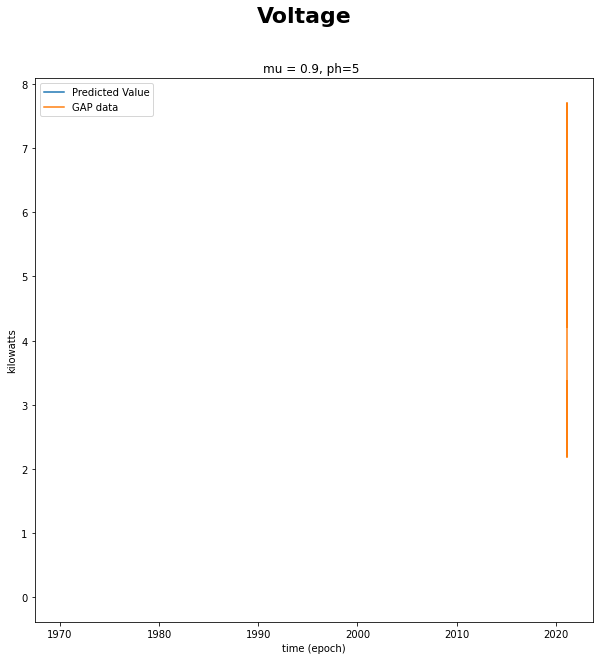

In [21]:
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Voltage', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

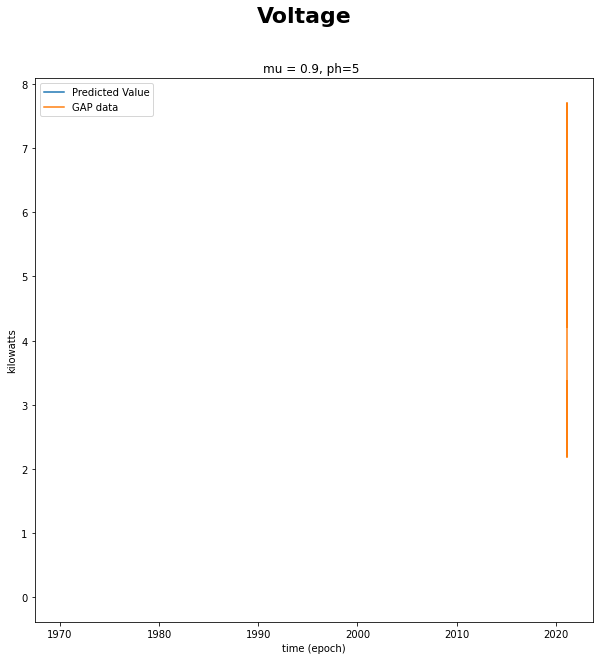

In [22]:
#Plot last 200 data points/predictions for the expanded data
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Voltage', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:-200], yp_pred[:-200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [23]:
#Calculate RMSE of predictions for the expanded data
mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)


RMSE:  2.1549368256504664


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: The model visualazation is still producing errors.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: I might utilize an AutoRegressive Integrated Moving Average (ARIMA) model if I were to use a different model. These are among the most commonly employed time series forecasting methods: In an autoregressive model, forecasts are linear combinations of the variable's past values.

In [27]:
#create your alternative training data here


ph = 60 * 5 #5 minutes
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [28]:
#re-run the prediction code here
for i in range(3, n_s+1):
    # get x and y data "available" for our prediction
    ts_tmp = ts.iloc[i-3:i-1, :]
    ys_tmp = ys.iloc[i-3:i, :]
    ns = len(ys_tmp)
    
    weights = np.array([mu**(i-1-k) for k in range(ns)])
    weights = np.flip(weights, 0)
        
    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1, 0]
    tp_unix = tp.timestamp()
    yp = np.dot(m_tmp, np.array([tp_unix, voltage_value])) + q_tmp
      
    tp_pred[1, i] = tp + ph
    yp_pred[1, i] = yp

ValueError: ignored

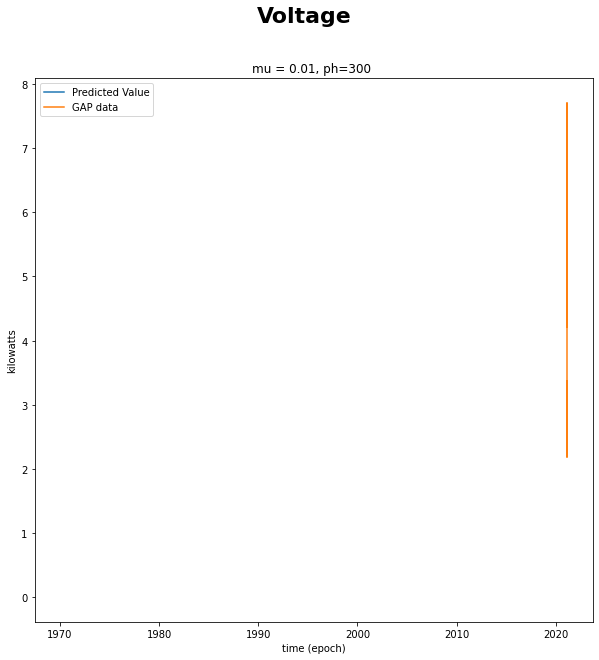

In [29]:
#Plot first 200 data points/predictions for alternative model
#Plot last 200 data points/predictions for the expanded data
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Voltage', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

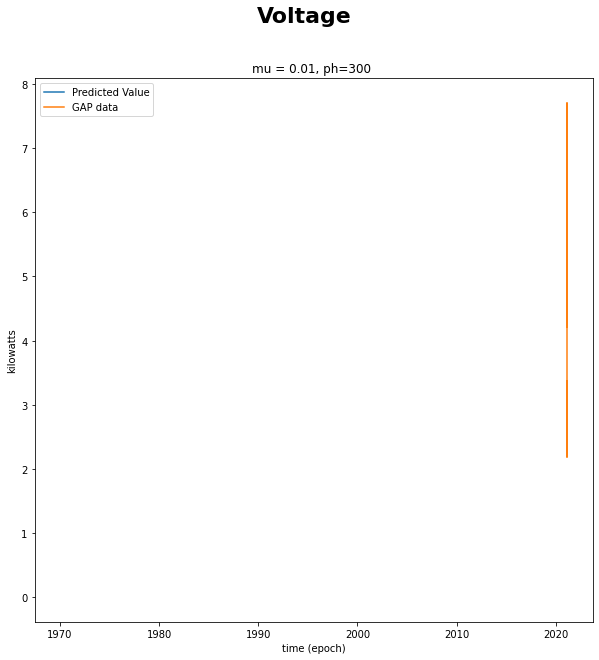

In [30]:
#Plot last 200 data points/predictions for alternative model
#Plot last 200 data points/predictions for the expanded data
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Voltage', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:-200], yp_pred[:-200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [31]:
#Calculate RMSE of predictions for alternative model
mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)


RMSE:  2.1549368256504664


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: My model resulted in similar results as the guided section of the lab. To improve the model I could increase the time from 5 days to 30 days so that it can gather more data.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.